In [1]:
import os, sys
import numpy as np
import json
import random
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import SGD, Adam
import tqdm
import matplotlib.pyplot as plt
import seaborn as sns

## Preliminary

In [2]:
NUM_ITER = 20
k = 5000 #use for taking expectation in computing loss

In [3]:
torch.manual_seed(12345)
device = torch.device("cuda:0" if torch.cuda.is_available() else 'cpu')
na_list = ['A', 'C', 'G', 'T'] #nucleic acids
aa_list = ['R', 'L', 'S', 'A', 'G', 'P', 'T', 'V', 'N', 'D', 'C', 'Q', 'E', 'H', 'I', 'K', 'M', 'F', 'W', 'Y'] #amino acids
NNK_freq = [0.09375]*3 + [0.0625]*5 + [0.03125]*13 #freq of 21 NNK codons including the stop codon
sum_20 = 0.0625*5 + 0.09375*3 + 0.03125*12 #sum of freq without the stop codon
pvals = [0.09375/sum_20]*3 + [0.0625/sum_20]*5 + [0.03125/sum_20]*12 #normalize freq for 20 codons
pvals = [0.09375/sum_20]*3 + [0.0625/sum_20]*5 + [0.03125/sum_20]*11 + \
        [1- sum([0.09375/sum_20]*3 + [0.0625/sum_20]*5 + [0.03125/sum_20]*11)] 
        #adjust sum to 1 due to numerical issue
aa_dict = dict(zip(aa_list, pvals))

## Dataset & Sampling

In [4]:
def construct_dataset():
    with open(aptamer_dataset_file, 'r') as f:
        aptamer_data = json.load(f)
    ds = []
    for aptamer in aptamer_data:
        peptides = aptamer_data[aptamer]
        if aptamer == "CTTTGTAATTGGTTCTGAGTTCCGTTGTGGGAGGAACATG": #took out aptamer control
            continue
        for peptide, _ in peptides:
            peptide = peptide.replace("_", "") #removed stop codons
            if "RRRRRR" in peptide: #took out peptide control
                continue
            if len(aptamer) == 40 and len(peptide) == 8: #making sure right length
                ds.append((aptamer, peptide))
    ds = list(set(ds)) #removed duplicates
    return ds

# Sample x from P_X (assume apatamers follow uniform)
def get_x():
    x_idx = np.random.randint(0, 4, 40)
    x = ""
    for i in x_idx:
        x += na_list[i]
    return x

# Sample y from P_y (assume peptides follow NNK)
def get_y():
    y_idx = np.random.choice(20, 7, p=pvals)
    y = "M"
    for i in y_idx:
        y += aa_list[i]
    return y

# S'(train/test) contains S_train/S_test with double the size of S_train/S_test
def get_S_prime(kind="train"):
    if kind == "train":
        dset = S_train
    else:
        dset = S_test
    k = len(dset)
    S_prime_dict = dict.fromkeys(dset, 0) #indicator 0 means in S
    for _ in range(k):
        pair = (get_x(), get_y())
        S_prime_dict[pair] = 1 #indicator 1 means not in S
    S_prime = [[k,int(v)] for k,v in S_prime_dict.items()] 
    np.random.shuffle(S_prime)
    return S_prime

# S new contains unseen new examples
def get_S_new(k):
    S_new = []
    for i in range(k):
        pair = (get_x(), get_y())
        S_new.append(pair)
    np.random.shuffle(S_new)
    S_new_train = S_new[:int(0.8*k)]
    S_new_test = S_new[int(0.8*k):]
    return S_new, S_new_train, S_new_test
    
# Returns pmf of an aptamer
def get_x_pmf():
    return 0.25**40

# Returns pmf of a peptide
def get_y_pmf(y):
    pmf = 1
    for char in y[1:]: #skips first char "M"
        pmf *= aa_dict[char]
    return pmf    

In [5]:
aptamer_dataset_file = "../data/aptamer_dataset.json"
S = construct_dataset()
n = len(S)
m = int(0.8*n) #length of S_train
S_train = S[:m]
S_test = S[m:]
S_prime_train = get_S_prime("train") #use for sgd 
S_prime_test = get_S_prime("test") #use for sgd 
S_new, S_new_train, S_new_test = get_S_new(10*n) #use for eval
train_ds = np.hstack((S_train, S_prime_train[:len(S_prime_train)//2]))

## NN Model

In [6]:
class SimpleConvNet(nn.Module):
    def __init__(self):
        super(SimpleConvNet, self).__init__()
        self.cnn_apt_1 = nn.Conv2d(1, 120, (4,4)) #similar to 4-gram
        self.cnn_pep_1 = nn.Conv2d(1, 50, (4,20))
        self.relu = nn.ReLU()
        self.fc1 = nn.Linear(4690, 1)
        
    def forward(self, apt, pep):
        apt = self.cnn_apt_1(apt)
        apt = self.relu(apt)
        pep = self.cnn_pep_1(pep)
        pep = self.relu(pep)
        apt = apt.view(-1, 1).T
        pep = pep.view(-1, 1).T
        
        x = torch.cat((apt, pep), 1)
        x = self.fc1(x)
        x = torch.sigmoid(x)
        return x

def weights_init(m):
    if isinstance(m, nn.Conv2d):
        nn.init.xavier_uniform_(m.weight.data, gain=nn.init.calculate_gain('relu'))
        nn.init.zeros_(m.bias.data)
    if isinstance(m, nn.Linear):
        nn.init.kaiming_normal_(m.weight.data, nonlinearity='sigmoid')
        nn.init.zeros_(m.bias.data)

## Helper methods

In [7]:
## Takes a peptide and aptamer sequence and converts to one-hot matrix
def one_hot(sequence, seq_type='peptide'):
    if seq_type == 'peptide':
        letters = aa_list
    else:
        letters = na_list
    one_hot = np.zeros((len(sequence), len(letters)))
    for i in range(len(sequence)):
        char = sequence[i]
        for _ in range(len(letters)):
            idx = letters.index(char)
            one_hot[i][idx] = 1
    return one_hot

# Convert a pair to one-hot tensor
def convert(apt, pep): 
    apt = one_hot(apt, seq_type='aptamer') #(40, 4)
    pep = one_hot(pep, seq_type='peptide') #(8, 20)
    apt = torch.FloatTensor(np.reshape(apt, (1, 1, apt.shape[0], apt.shape[1]))).cuda() #(1, 1, 40, 4)
    pep = torch.FloatTensor(np.reshape(pep, (1, 1, pep.shape[0], pep.shape[1]))).cuda() #(1, 1, 8, 20)
    return apt, pep

def update(x, y):
    x.requires_grad=True
    y.requires_grad=True
    x = x.cuda()
    y = y.cuda()
    out = model(x, y)
    return out

def loss_samples(k, ds='train'): # S_train/S_test
    if ds == 'train':
        dset = S_train
    else:
        dset = S_test
    pairs = []
    for (apt, pep) in dset[:k]:
        x, y = convert(apt, pep)
        pairs.append((x, y))
    return pairs

def prime_loss_samples(k, ds='train'): # S_prime_train/S_prime_test
    if ds == "train":
        dset = S_prime_train[len(S_prime_train)//2:]    
    else:
        dset = S_prime_test[len(S_prime_test)//2:]
    pairs = []
    for (apt, pep), ind in dset[:k]:
        pmf = get_y_pmf(pep)
        x, y = convert(apt, pep)
        pairs.append((x, y, ind, pmf))
    return pairs
    
def get_log_out(dataset='train'):
    outs = []
    if dataset == 'train':
        dset = train_loss_samples
    else:
        dset = test_loss_samples
    for (apt, pep) in dset:
        out = update(apt, pep)
        outs.append(torch.log(out).cpu().detach().numpy().flatten()[0])
    return np.average(outs)

def get_out_prime(ds="train"):
    outs = []
    if ds == "train":
        dset = prime_train_loss_samples
        leng = 2*m
    else:
        dset = prime_test_loss_samples
        leng = 2*(n-m)
    for (apt, pep, ind, pmf) in dset:
        x = apt.cuda()
        y = pep.cuda()
        out = model(x, y)
        out_is = out.cpu().detach().numpy().flatten()[0] * pmf * get_x_pmf() * leng * ind
        outs.append(out_is)
        res = np.average(outs)
    return res

def plot_loss(train_loss, test_loss, i, j, lamb, gamma):
    plt.plot(train_loss, 'b', label='Train loss')
    plt.plot(test_loss, 'y', label='Test loss')
    plt.title('Loss after ' +  str(i) + " iterations, " + str(j) + " epochs, " + 'lambda =%.5f' % lamb  + ' gamma =%.5f' % gamma)
    plt.legend()
    plt.show()

def plot_recall(train_recall, test_recall, i, j, lamb, gamma):
    plt.plot(train_recall, 'b', label='Train recall')
    plt.plot(test_recall, 'y', label='Test recall')
    plt.title('Recall after ' + str(i) + " iterations, " + str(j) + " epochs, " + 'lambda =%.5f' % lamb  + ' gamma =%.5f' % gamma)
    plt.legend()
    plt.show()
    
def plot_cdf(train_cdf, test_cdf, i, j, lamb, gamma):
    plt.plot(train_cdf, 'b', label='Train CDF')
    plt.plot(test_cdf, 'y', label='Test CDF')
    plt.title('CDF after ' + str(i) + " iterations, " + str(j) + " epochs, " + 'lambda =%.5f' % lamb  + ' gamma =%.5f' % gamma)
    plt.legend()
    plt.show()

In [8]:
train_loss_samples = loss_samples(k, 'train')
test_loss_samples = loss_samples(k, 'test')
prime_train_loss_samples = prime_loss_samples(k, 'train')
prime_test_loss_samples = prime_loss_samples(k, 'test')

## SGD

In [9]:
def sgd(lamb=1e28, #hyperparam
        gamma=1e-3): #step size
    
    optim = SGD(model.parameters(), lr=gamma)

    for j in range(NUM_ITER):
        
        train_losses = []
        train_recalls = []
        train_recall_outputs = [] 

        test_losses = []
        test_recalls = []
        test_recall_outputs = []

        new_outputs = []

        train_correct = 0
        test_correct = 0
        
        for i, ele in enumerate(tqdm.tqdm(train_ds)):
            if i == 0:
                continue
            model.train()
            optim.zero_grad() #reset gradients after update
            x, y = convert(ele[0], ele[1]) #sample x,y from S_train
            out = update(x, y) #get S_train output/score
            log_out = torch.log(out) #take log
            # Calculate train recall
            train_score = out.cpu().detach().numpy().flatten()[0] #get score in float
            if train_score > 0.6:
                train_correct += 1 #contribute to train recall
            train_recall_outputs.append(train_score) #store the train scores

            optim.zero_grad() #reset gradients for the second branch
            y_pmf = get_y_pmf(ele[2][1])
            x_prime, y_prime = convert(ele[2][0], ele[2][1]) #sample x', y' from S_prime_train
            out_prime = update(x_prime, y_prime) #get score'
            out_prime = out_prime*y_pmf*get_x_pmf()*2*m #adjust for IS
            const = ele[3] #indicator
            (lamb*const*out_prime - log_out).backward(retain_graph=True) #backprop
            optim.step() #gradient update

            model.eval()
            x_test, y_test = convert(S_test[i%(n-m)][0], S_test[i%(n-m)][1]) #sample x,y from test set
            test_score = model(x_test, y_test).cpu().detach().numpy().flatten()[0] #get test score in float
            test_recall_outputs.append(test_score) #store the test scores
            if test_score > 0.6:
                test_correct += 1 #contribute to test recall

            #generate 10 unseen examples from S_new as compared 1 example from validate/train for cdfs
            for x, y in S_new[10*i:10*(i+1)]:
                x_new, y_new = convert(x, y) #generate unseen x'' and y'' from S_new
                new_score = model(x_new, y_new).cpu().detach().numpy().flatten()[0] #get unknown score
                new_outputs.append(new_score) #store the new unknown scores

            if i % 2000 == 0:
                train_loss = lamb*get_out_prime("train") - get_log_out('train') #training loss
                test_loss = (m/(n-m))*lamb*get_out_prime("test") - get_log_out('test') #test loss
                train_losses.append(train_loss)
                test_losses.append(test_loss)

                train_recall = 100*train_correct/i #training recall
                train_recalls.append(train_recall) 
                test_recall = 100*test_correct/i #test recall
                test_recalls.append(test_recall)
                if i > 1000:
                    train_score = np.asarray(new_outputs[-10000:] + train_recall_outputs[-1000:]) 
                    test_score = np.asarray(new_outputs[-10000:] + test_recall_outputs[-1000:])
                else:
                    train_score = np.asarray(new_outputs + train_recall_outputs) #combine train and unknown scores
                    test_score = np.asarray(new_outputs + test_recall_outputs) #combibne test and unknown scores
                train_cdf = np.cumsum(train_score)/np.sum(train_score) #train cdf
                test_cdf = np.cumsum(test_score)/np.sum(test_score) #test cdf


            if i % 20000 == 0:
                plot_recall(train_recalls, test_recalls, i, j, lamb, gamma)
                plot_loss(train_losses, test_losses, i, j, lamb, gamma)
                plot_cdf(train_cdf, test_cdf, i, j, lamb, gamma)
                print("New score: ", np.average(new_outputs[-20:]))
                print("Train score: ", np.average(train_score[-20:]))
                print("Test score: ", np.average(test_score[-20:]))

## Hyperparameter tuning

In [10]:
gammas = [1e-3]
lambdas = [1e28]

  4%|▍         | 19993/473047 [06:00<1:39:21, 76.00it/s]  

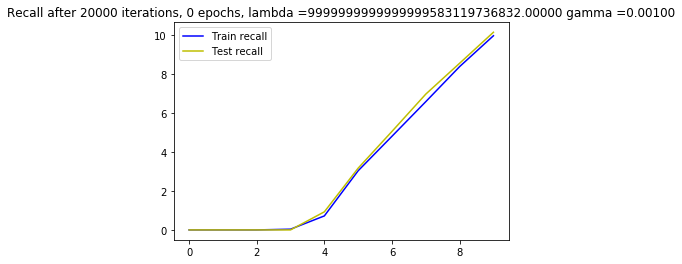

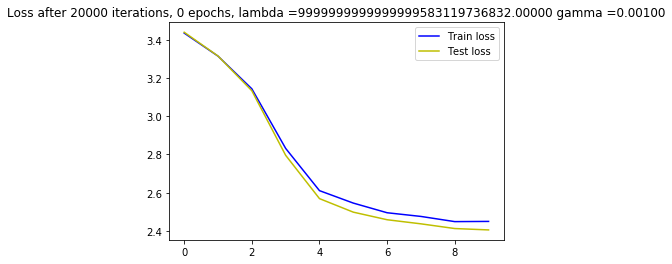

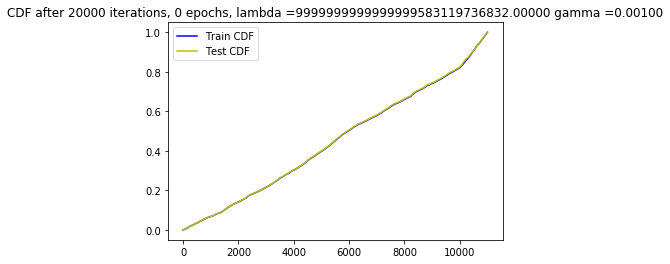

  4%|▍         | 20009/473047 [06:12<38:57:22,  3.23it/s]

New score:  0.15981339
Train score:  0.3856625
Test score:  0.37926593


  8%|▊         | 39993/473047 [12:13<1:35:10, 75.83it/s]  

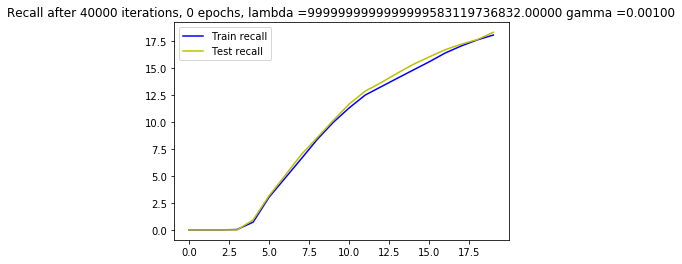

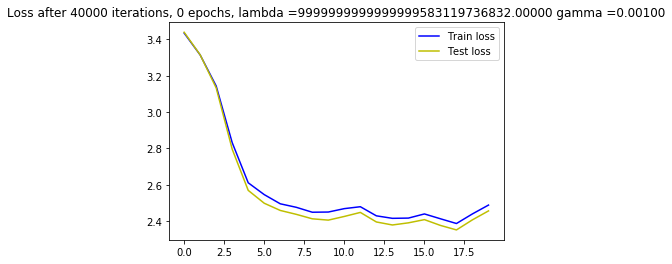

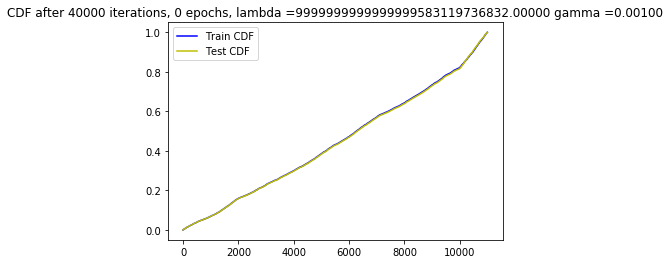

  8%|▊         | 40009/473047 [12:25<37:27:04,  3.21it/s]

New score:  0.15216315
Train score:  0.36700234
Test score:  0.26681808


 13%|█▎        | 59993/473047 [18:32<1:33:01, 74.00it/s]  

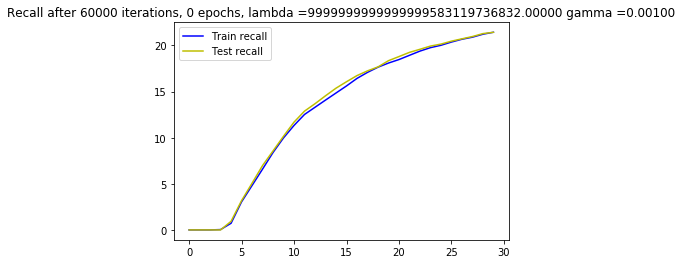

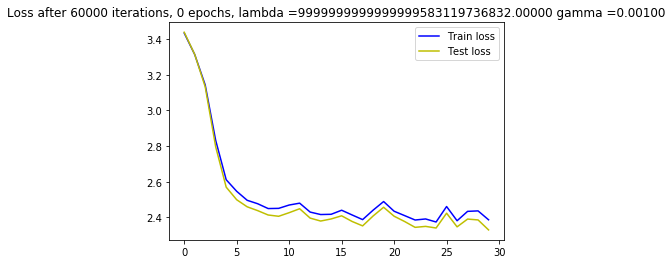

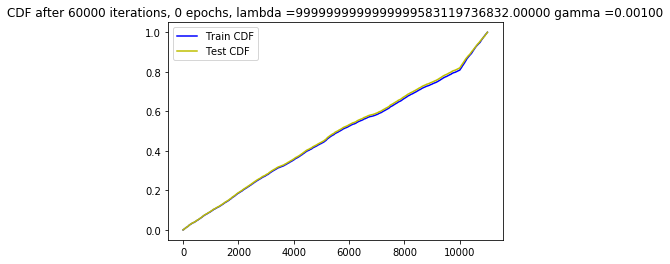

 13%|█▎        | 60009/473047 [18:45<40:08:59,  2.86it/s]

New score:  0.17391677
Train score:  0.3968213
Test score:  0.45213088


 17%|█▋        | 79996/473047 [24:51<1:27:30, 74.86it/s] 

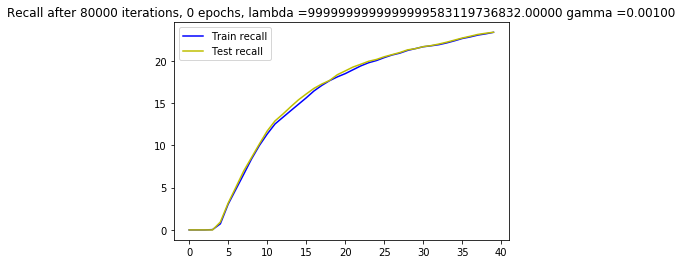

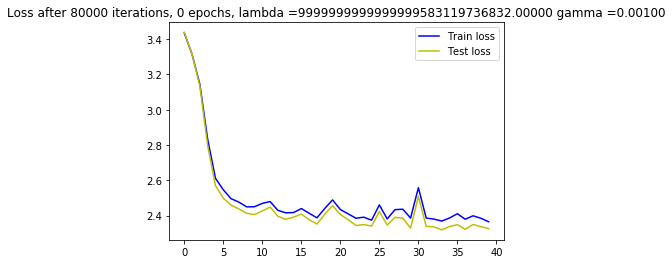

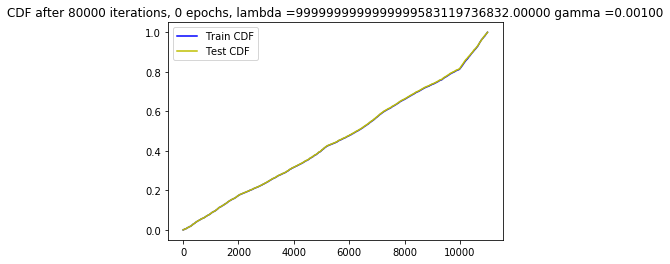

 17%|█▋        | 80012/473047 [25:03<34:38:27,  3.15it/s]

New score:  0.21209876
Train score:  0.37147278
Test score:  0.4353253


 21%|██        | 99994/473047 [31:20<1:21:11, 76.57it/s] 

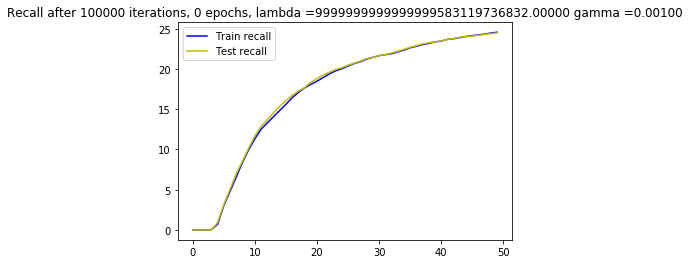

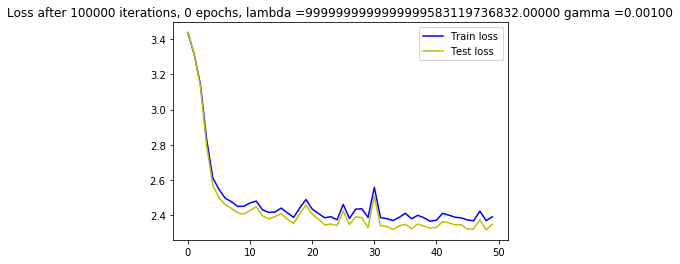

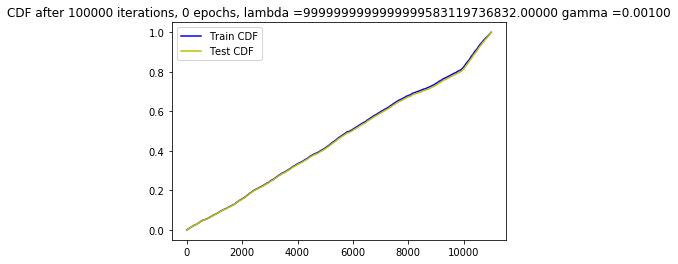

 21%|██        | 100009/473047 [31:20<36:46:27,  2.82it/s]

New score:  0.24716172
Train score:  0.33009067
Test score:  0.40266642


 25%|██▌       | 119993/473047 [37:24<1:19:02, 74.44it/s] 

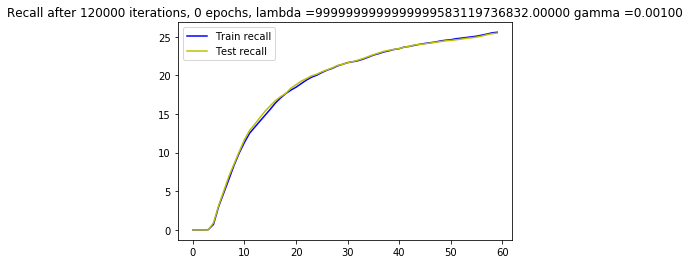

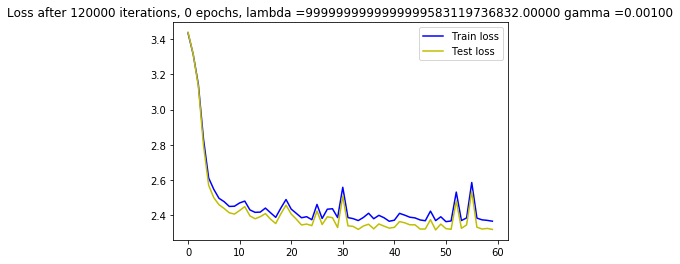

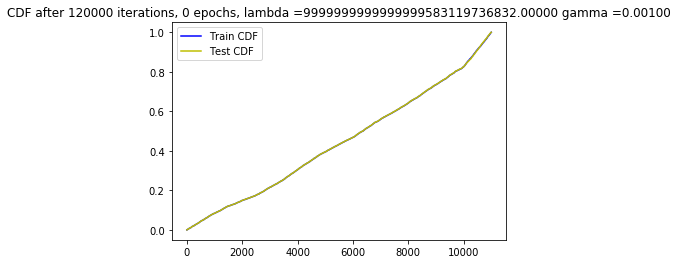

 25%|██▌       | 120009/473047 [37:35<30:46:59,  3.19it/s]

New score:  0.15856116
Train score:  0.38943285
Test score:  0.25210264


 30%|██▉       | 139993/473047 [43:37<1:15:07, 73.88it/s]  

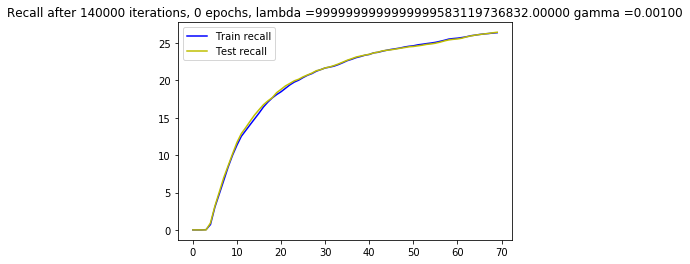

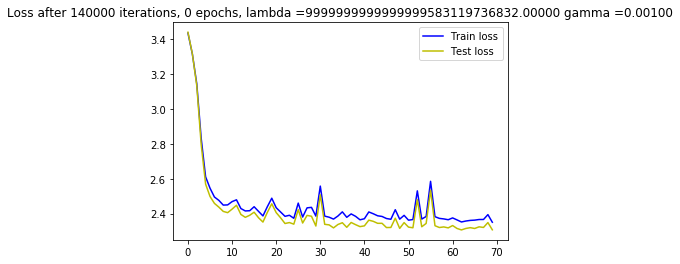

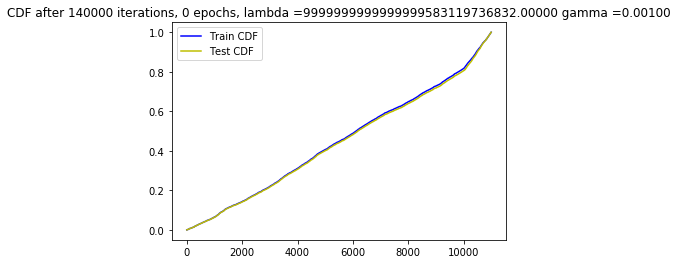

 30%|██▉       | 140009/473047 [43:49<29:15:52,  3.16it/s]

New score:  0.19521663
Train score:  0.4240911
Test score:  0.32818744


 34%|███▍      | 159993/473047 [49:55<1:09:14, 75.35it/s] 

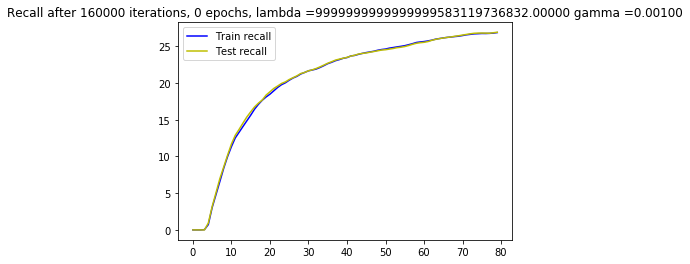

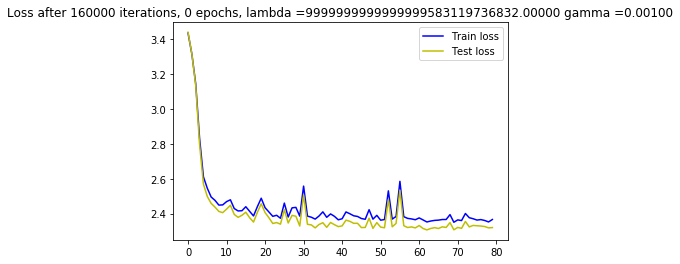

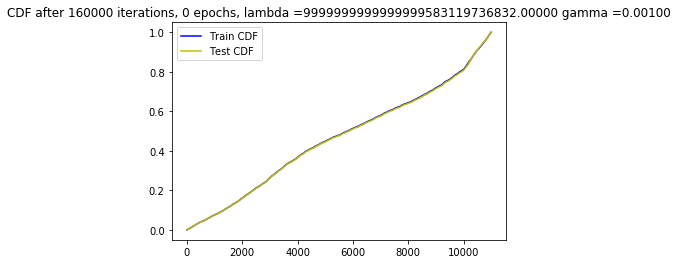

 34%|███▍      | 160009/473047 [50:07<27:43:58,  3.14it/s]

New score:  0.091426075
Train score:  0.42319298
Test score:  0.49008694


 38%|███▊      | 179999/473047 [56:14<1:05:08, 74.98it/s] 

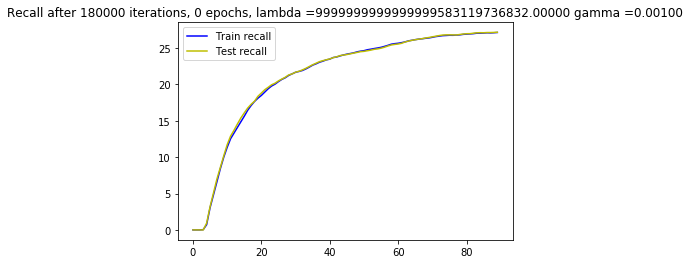

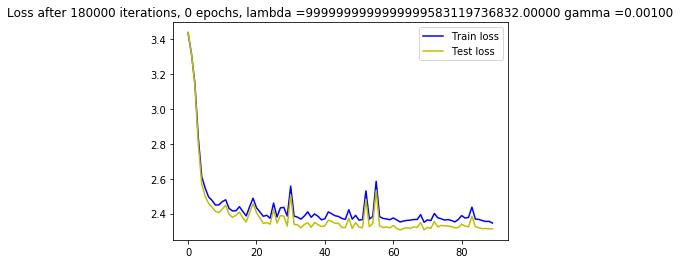

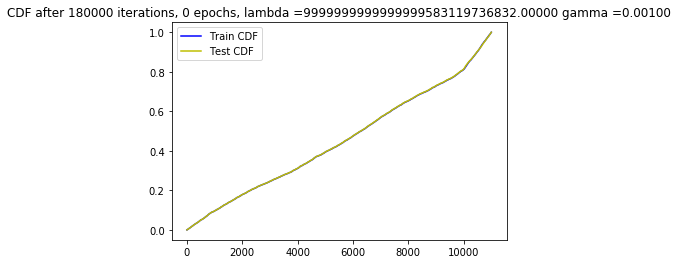

 38%|███▊      | 180015/473047 [56:26<25:55:38,  3.14it/s]

New score:  0.24889298
Train score:  0.47715554
Test score:  0.47799355


 42%|████▏     | 199999/473047 [1:02:33<1:01:28, 74.03it/s] 

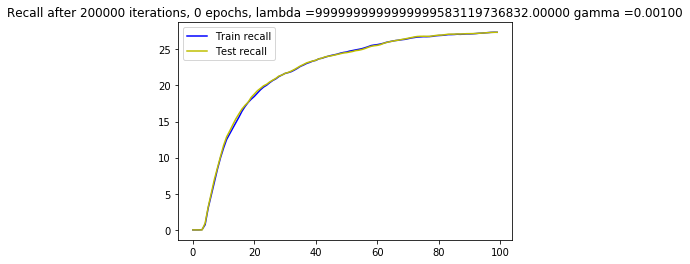

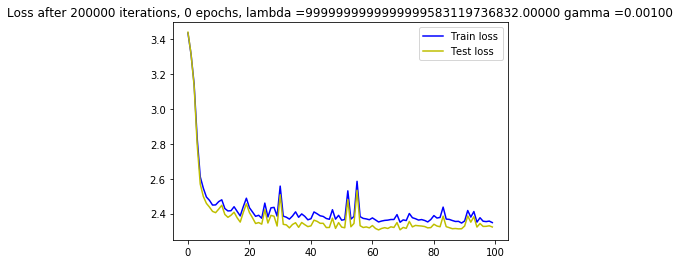

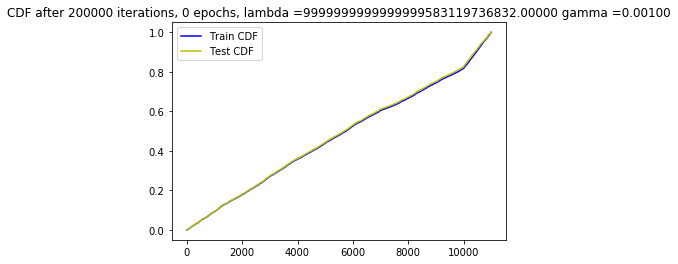

 42%|████▏     | 200015/473047 [1:02:45<24:14:02,  3.13it/s]

New score:  0.23355833
Train score:  0.29879683
Test score:  0.33455127


 47%|████▋     | 219993/473047 [1:08:52<56:23, 74.80it/s]    

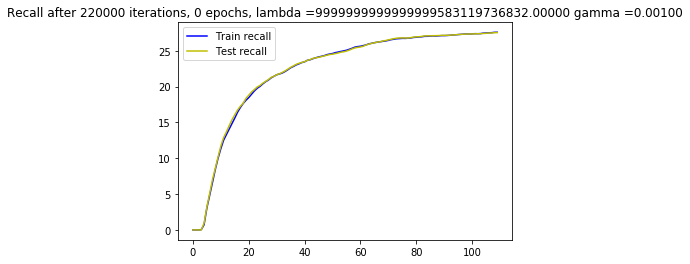

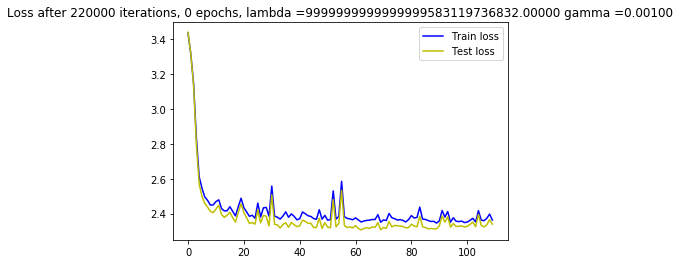

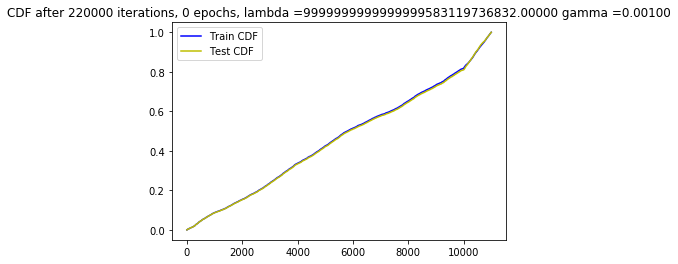

 47%|████▋     | 220009/473047 [1:09:04<22:32:02,  3.12it/s]

New score:  0.09047908
Train score:  0.35234007
Test score:  0.41412622


 51%|█████     | 239998/473047 [1:15:12<51:38, 75.21it/s]   

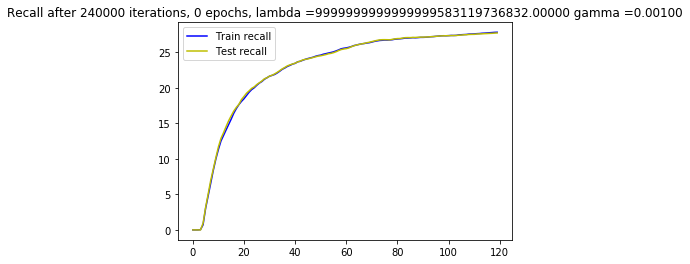

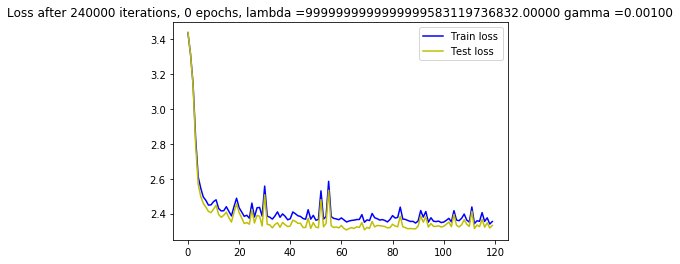

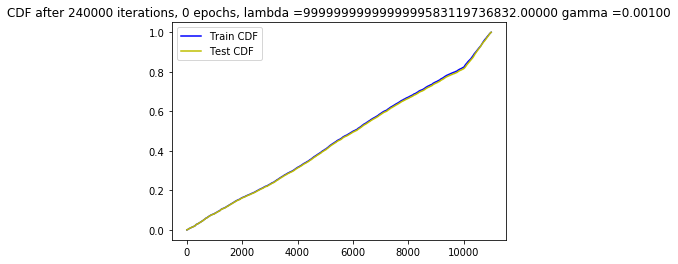

 51%|█████     | 240014/473047 [1:15:24<20:46:10,  3.12it/s]

New score:  0.07146152
Train score:  0.22009477
Test score:  0.32372078


 55%|█████▍    | 259993/473047 [1:21:32<47:35, 74.61it/s]   

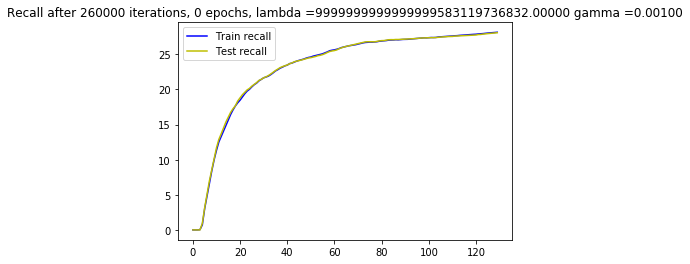

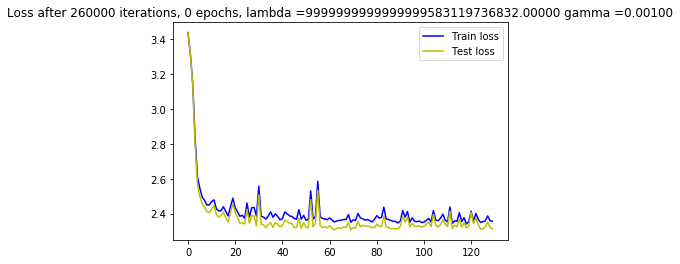

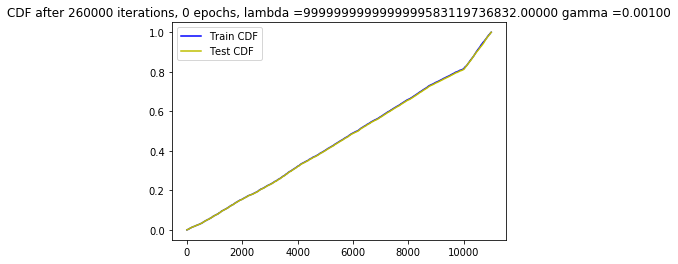

 55%|█████▍    | 260009/473047 [1:21:44<18:57:12,  3.12it/s]

New score:  0.24033733
Train score:  0.27497342
Test score:  0.37390974


 59%|█████▉    | 280000/473047 [1:45:40<3:39:16, 14.67it/s]   

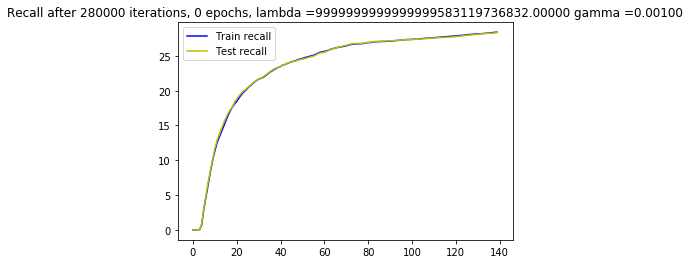

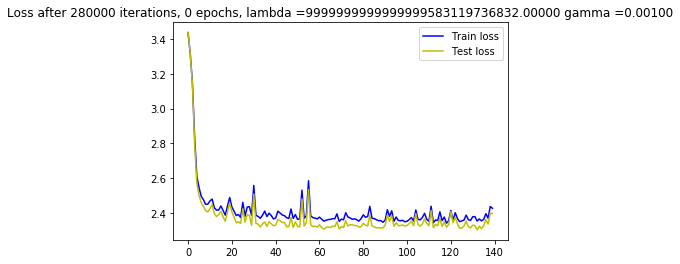

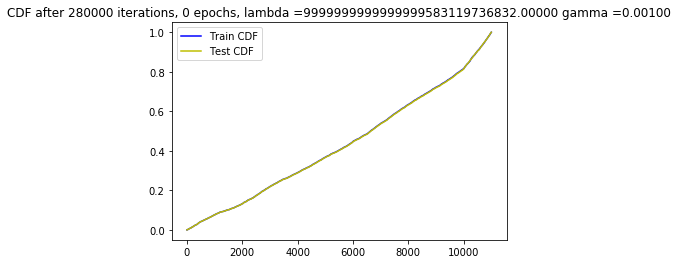

 59%|█████▉    | 280002/473047 [1:46:26<673:20:23, 12.56s/it]

New score:  0.23366575
Train score:  0.5101924
Test score:  0.4462329


 63%|██████▎   | 299999/473047 [2:20:10<2:29:34, 19.28it/s]  

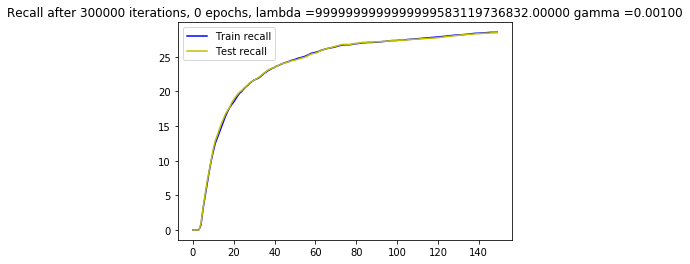

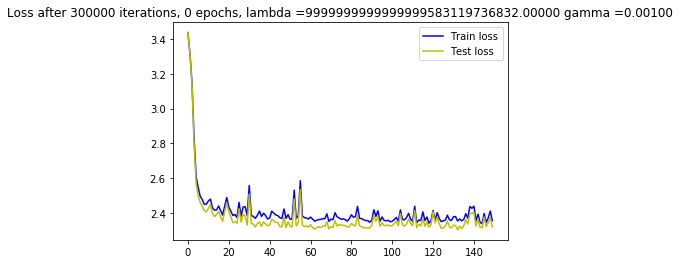

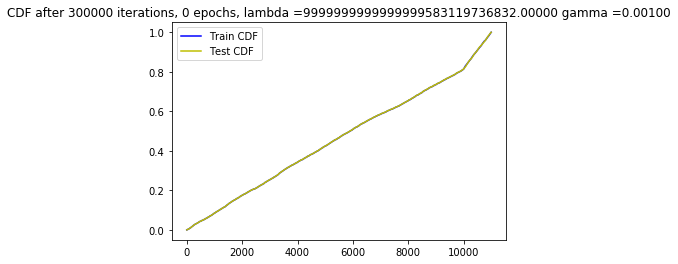

 63%|██████▎   | 300007/473047 [2:21:01<318:56:31,  6.64s/it]

New score:  0.22814497
Train score:  0.36699942
Test score:  0.33547798


 68%|██████▊   | 319999/473047 [2:53:20<3:01:54, 14.02it/s]  

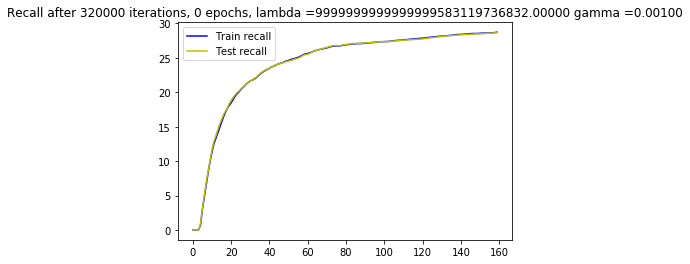

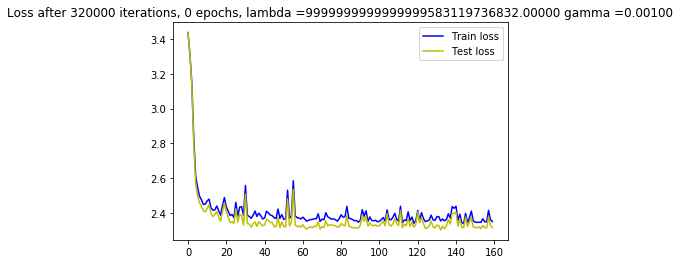

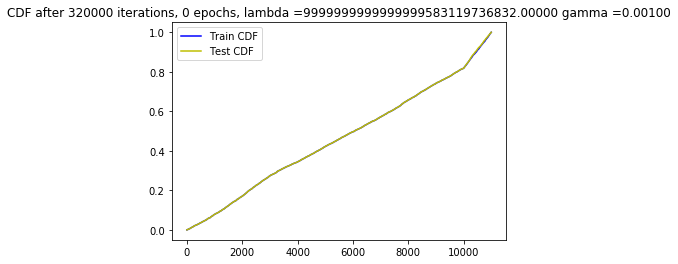

 68%|██████▊   | 320002/473047 [2:54:05<264:04:16,  6.21s/it]

New score:  0.10711199
Train score:  0.46943817
Test score:  0.41562444


 72%|███████▏  | 339998/473047 [3:26:30<1:29:10, 24.87it/s]  

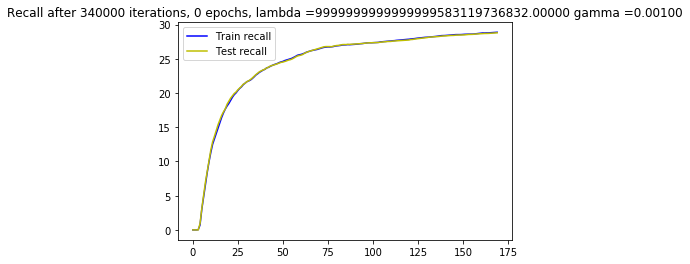

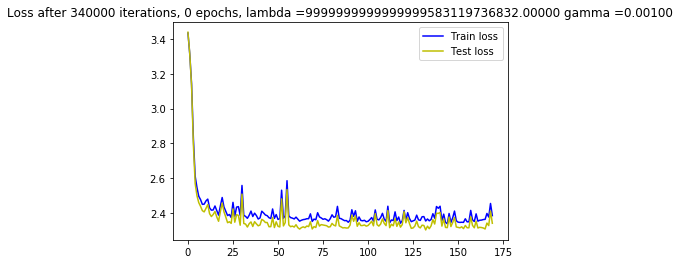

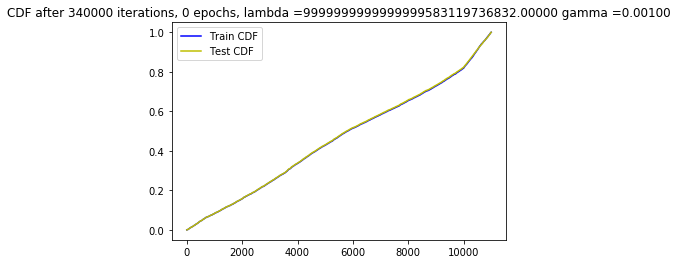

 72%|███████▏  | 340002/473047 [3:27:17<151:59:00,  4.11s/it]

New score:  0.14338495
Train score:  0.2914412
Test score:  0.44790182


 76%|███████▌  | 359997/473047 [3:59:30<1:02:38, 30.08it/s]  

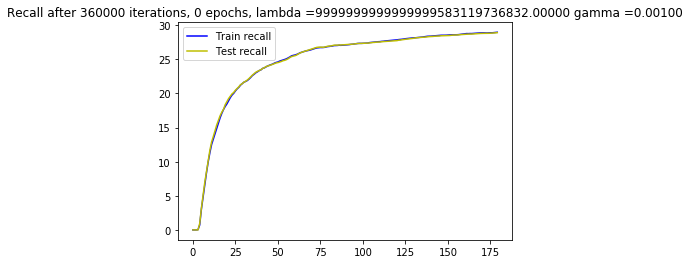

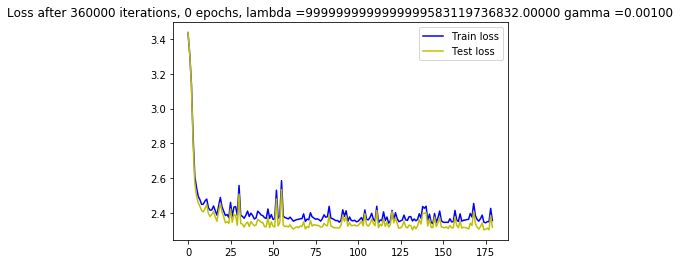

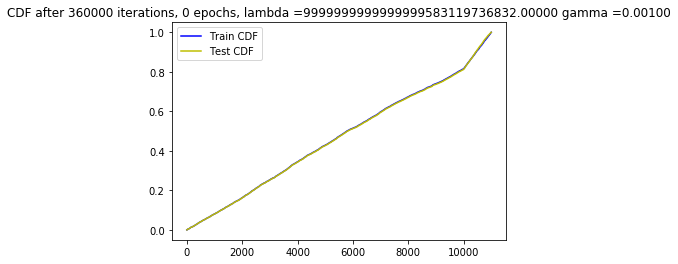

 76%|███████▌  | 360002/473047 [4:00:13<96:44:25,  3.08s/it] 

New score:  0.12970248
Train score:  0.4333837
Test score:  0.27280006


 80%|████████  | 380000/473047 [4:32:30<1:31:07, 17.02it/s]  

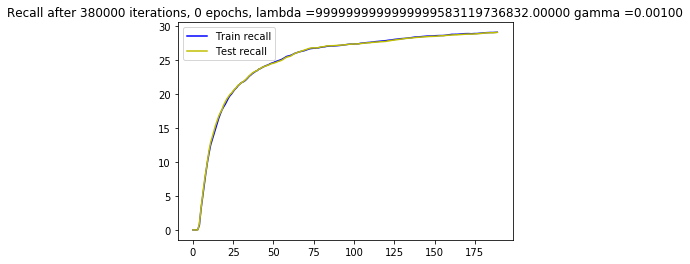

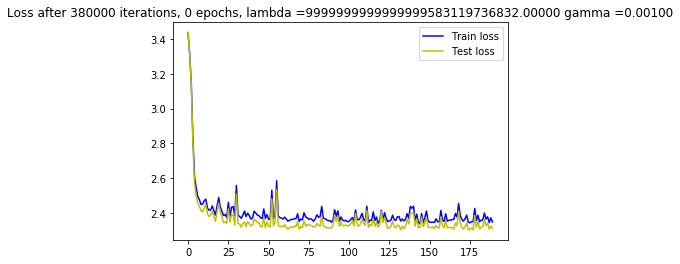

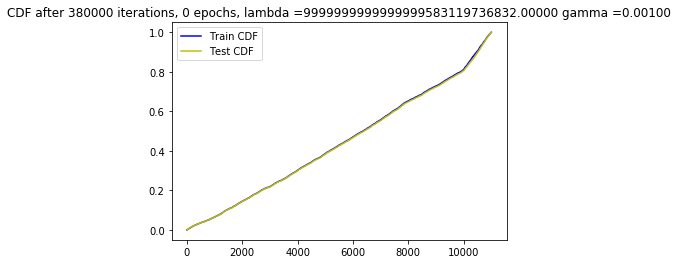

 80%|████████  | 380002/473047 [4:33:18<316:08:06, 12.23s/it]

New score:  0.17211834
Train score:  0.38152152
Test score:  0.36603907


 85%|████████▍ | 400000/473047 [5:05:40<2:13:21,  9.13it/s]  

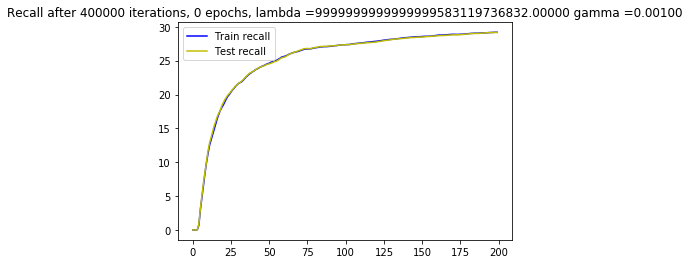

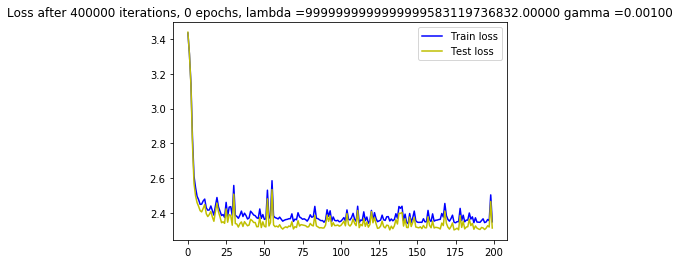

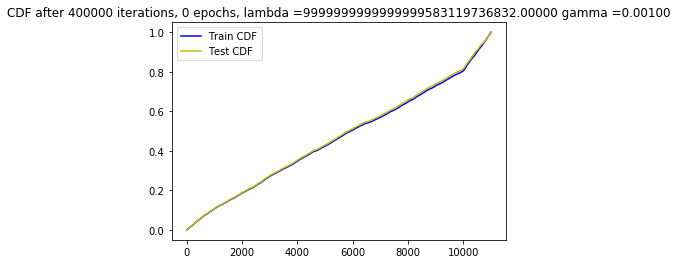

 85%|████████▍ | 400002/473047 [5:06:27<253:49:49, 12.51s/it]

New score:  0.104933046
Train score:  0.38882825
Test score:  0.3878459


 89%|████████▉ | 420000/473047 [5:38:40<1:38:28,  8.98it/s]  

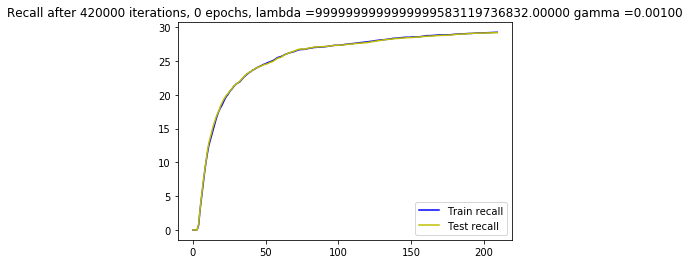

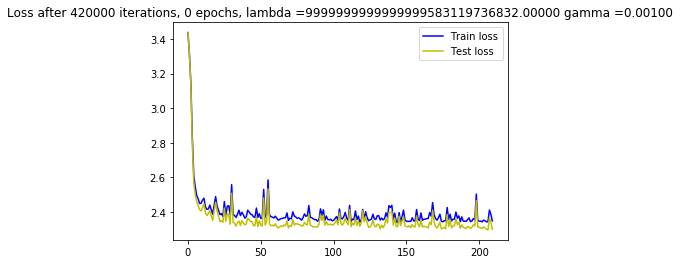

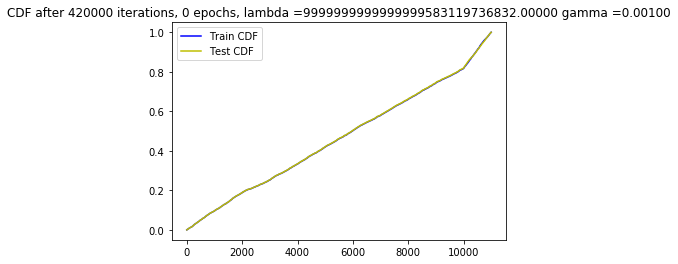

 89%|████████▉ | 420002/473047 [5:39:26<181:12:01, 12.30s/it]

New score:  0.14921887
Train score:  0.36761123
Test score:  0.39588836


 93%|█████████▎| 440000/473047 [6:11:50<22:47, 24.17it/s]    

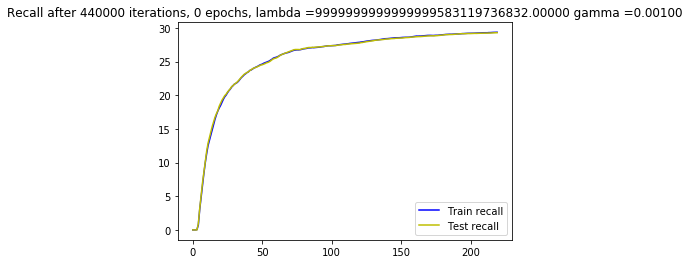

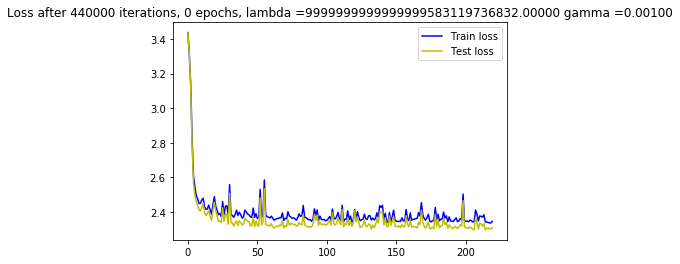

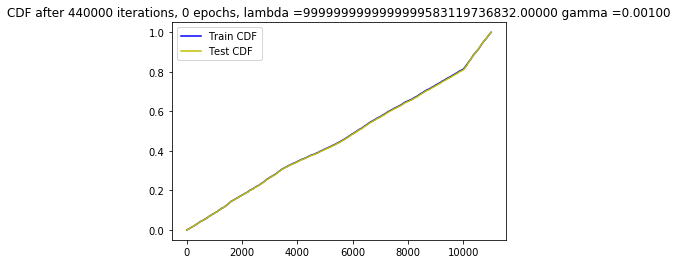

 93%|█████████▎| 440002/473047 [6:12:31<112:15:52, 12.23s/it]

New score:  0.108148195
Train score:  0.42644244
Test score:  0.348879


 97%|█████████▋| 459997/473047 [6:45:00<14:39, 14.84it/s]    

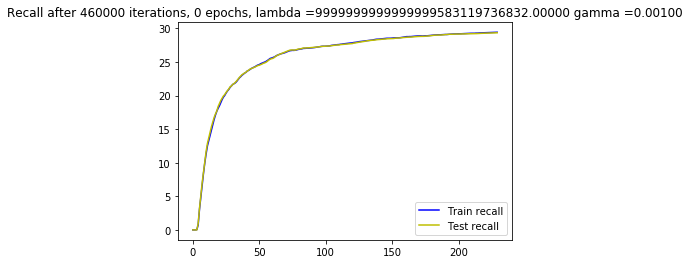

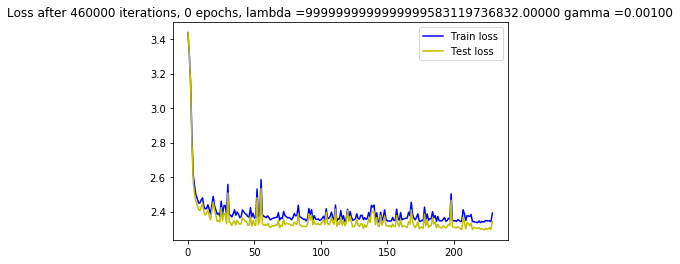

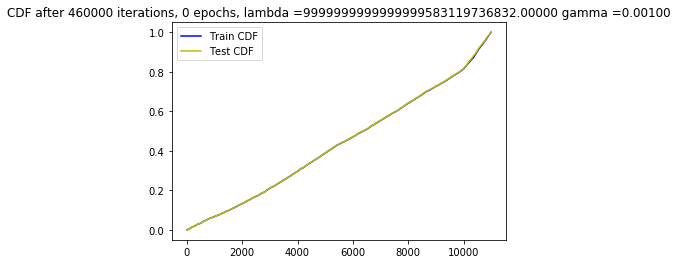

 97%|█████████▋| 460002/473047 [6:45:48<11:38:21,  3.21s/it]

New score:  0.3555326
Train score:  0.29382282
Test score:  0.5321868


  4%|▍         | 19997/473047 [34:10<12:28:31, 10.09it/s]  

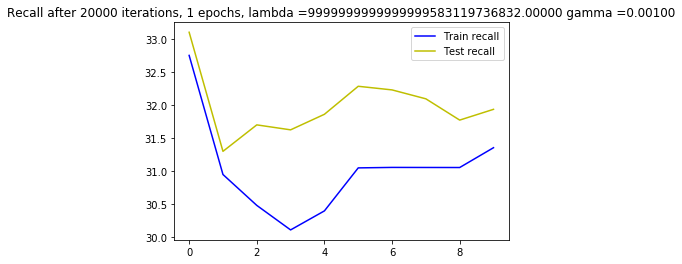

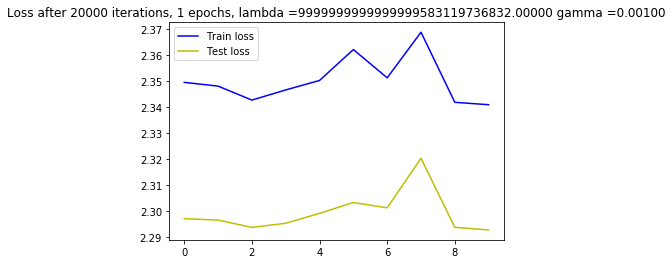

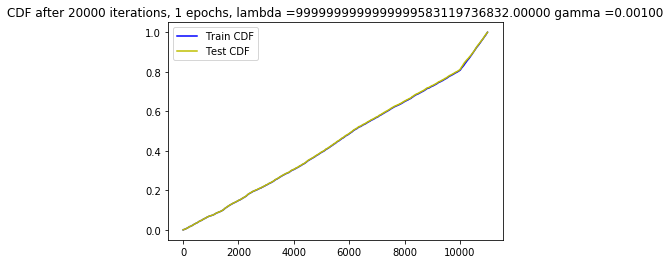

  4%|▍         | 20002/473047 [35:02<425:35:30,  3.38s/it]

New score:  0.1664636
Train score:  0.47600117
Test score:  0.43729743


  8%|▊         | 39999/473047 [1:08:40<7:49:00, 15.39it/s]   

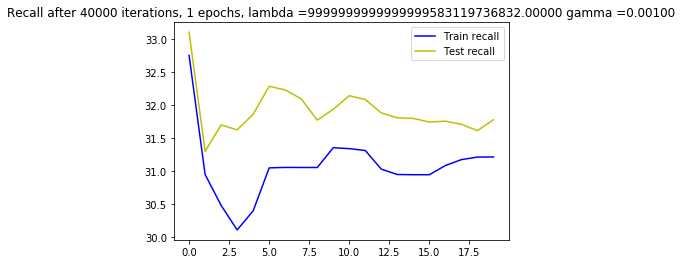

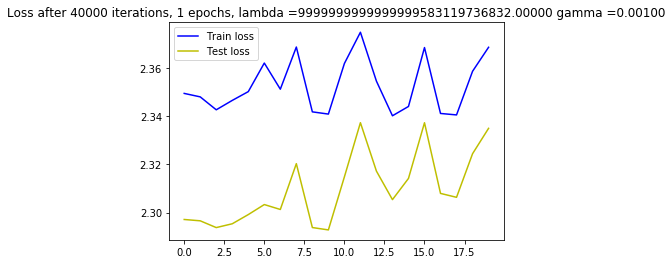

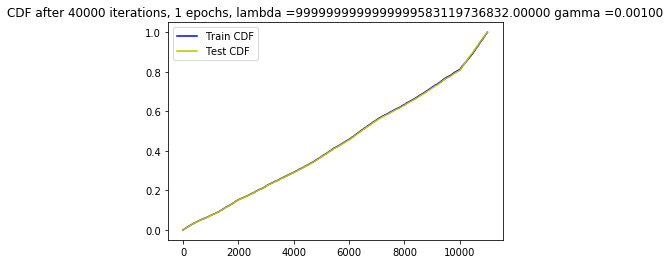

  8%|▊         | 40002/473047 [1:09:24<773:56:48,  6.43s/it] 

New score:  0.16897431
Train score:  0.47199613
Test score:  0.31875634


 12%|█▏        | 58955/473047 [1:40:55<12:38:56,  9.09it/s]  

In [ ]:
for g in range(len(gammas)):
    for l in range(len(lambdas)):
        model = SimpleConvNet()
        model.apply(weights_init)
        model.cuda()
        sgd(gamma=gammas[g], lamb=lambdas[l])